In [1]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import warnings
warnings.simplefilter('ignore')

In [11]:
i = 0
exclude = []

def get_files(instrument):
    df_frames = []
    path = f"/Users/joeybesseling/Documents/Programmeren/Projects/Data/{instrument}/"

    instrument = f"{instrument}"
    depth = 20

    found = True
    i = 5
    for i in range(25): # 350-660 # 1 - 880
        try:
            df = pd.read_parquet(path + f"{instrument}_1_{depth}({i}).parquet")
            df["timestamp"] = pd.to_datetime(df.timestamp)
            df = df.set_index("timestamp", drop = True)
            df = df.drop("Unnamed: 0", axis = 1)
            df_frames.append(df)
            i += 1
        except Exception as e:
            found = False
    df = pd.concat(df_frames)
    df = df.resample("1s").last()
    return df

eth = get_files("ETH-PERPETUAL")
btc = get_files("BTC-PERPETUAL")

In [12]:
df_save = pd.merge(eth, btc, left_index = True, right_index = True)
df_save = df_save.loc[df_save.bid1_price_x.notna()]
df_save = df_save.loc[df_save.bid1_price_y.notna()]
df_save = df_save.iloc[:]

In [13]:
df_save["mid_x"] = (df_save["bid1_price_x"] + df_save["ask1_price_x"]) / 2
df_save["mid_y"] = (df_save["bid1_price_y"] + df_save["ask1_price_y"]) / 2

In [14]:
THRESHOLD = .0001
df = df_save.copy().iloc[:100000]
SpreadX = (df["ask1_price_x"] - df["bid1_price_x"])/df["bid1_price_x"]
SpreadY = (df["ask1_price_y"] - df["bid1_price_y"])/df["bid1_price_y"]

Arb = df["mid_x"] / df["mid_y"]
ArbMean = (df["mid_x"] / df["mid_y"]).rolling(1000).apply(np.mean)

Dev = Arb - ArbMean
Dev = Dev.rolling(4).apply(np.mean)
Dir = Dev.copy()
Dir[Dev > SpreadX + THRESHOLD] = 1 # long y short x
Dir[-Dev > SpreadY + THRESHOLD] = -1 # long x short y
Dir[abs(Dir) != 1] = 0
df["dev"] = Dev
df["indicator"] = Dir

df["bid1_price_min_x"] = df.bid1_price_x.shift(-1)
df["ask1_price_max_x"] = df.ask1_price_x.shift(-1)
df["bid1_price_min_y"] = df.bid1_price_y.shift(-1)
df["ask1_price_max_y"] = df.ask1_price_y.shift(-1)

df["pos_y"] = Dir.apply(np.sign)
df["pos_x"] = -1 * df["pos_y"].copy()

ch_pos_x = df["pos_x"].diff()
ch_pos_y = df["pos_y"].diff()
fee_x = ch_pos_x.copy()
fee_y = ch_pos_x.copy()
fee_x[ch_pos_x != 0] = 0#-SpreadX[ch_pos_x != 0]/2
fee_y[ch_pos_y != 0] = 0#-SpreadY[ch_pos_y != 0]/2
fee_x[ch_pos_x == 0] = 0 
fee_y[ch_pos_y == 0] = 0
df["fee_x"] = fee_x
df["fee_y"] = fee_y


df["diff_x"] = df["mid_x"].apply(np.log).diff()
df["diff_y"] = df["mid_y"].apply(np.log).diff()

df["my_x"] = df["pos_x"].shift(1)*df["diff_x"] 
df["my_y"] = df["pos_y"].shift(1)*df["diff_y"] 

f_full = df.iloc[:]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


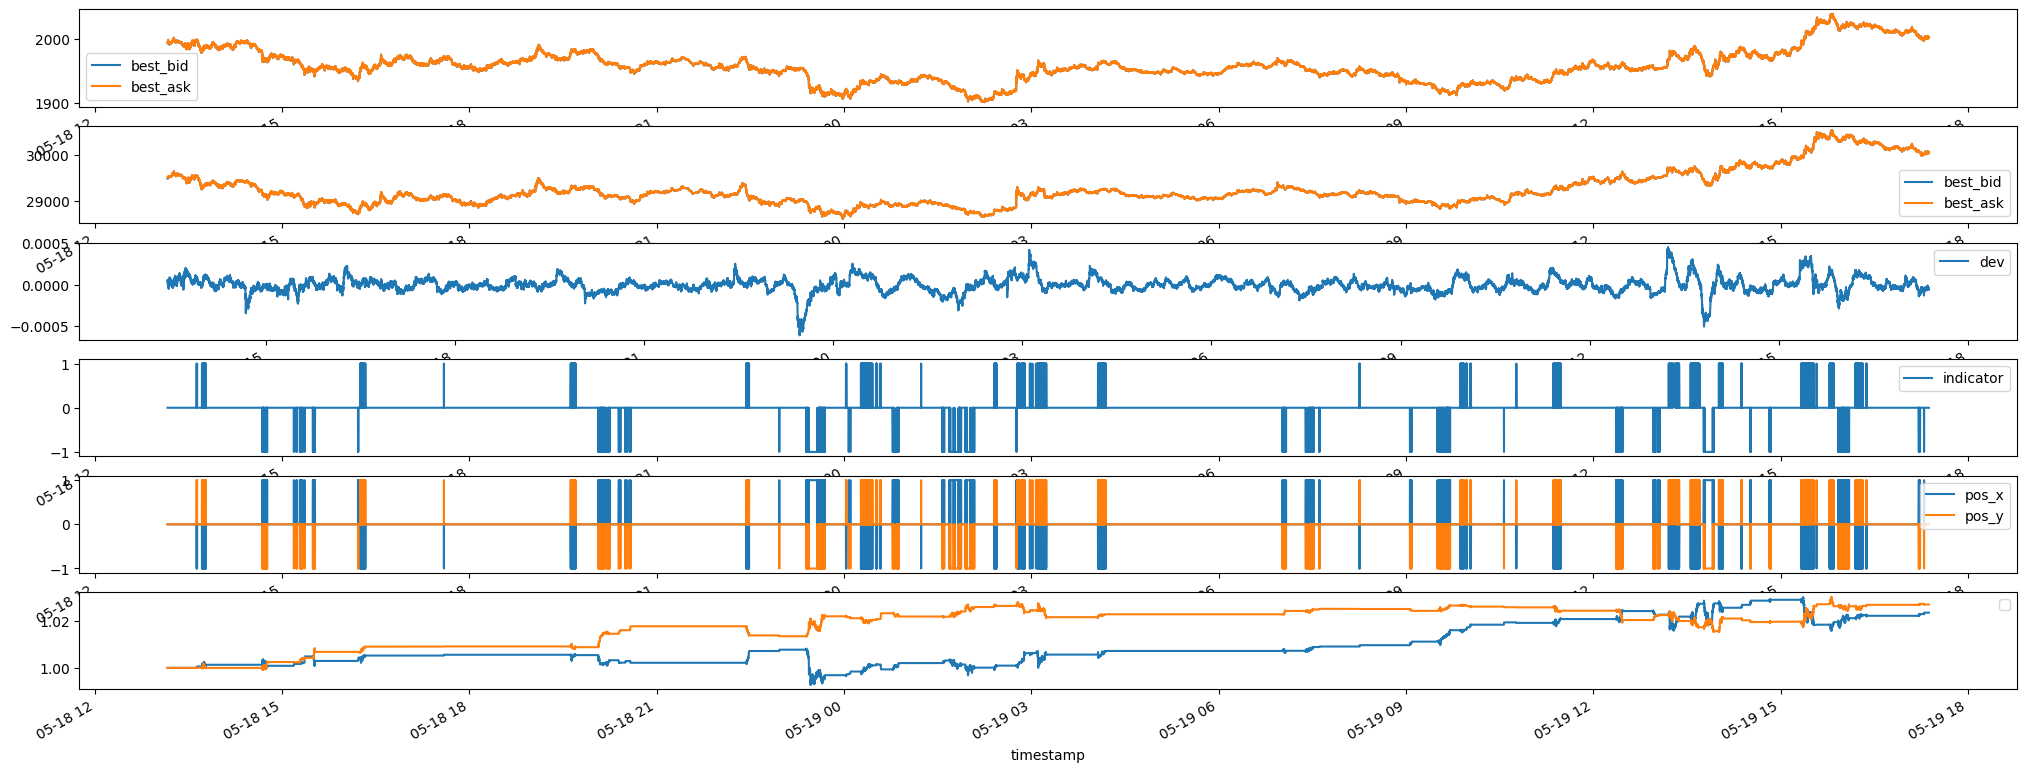

In [15]:
fig, axs = plt.subplots(6,1, figsize = (25,10))
f_full.bid1_price_x.plot(ax = axs[0], label = "best_bid")
f_full.ask1_price_x.plot(ax = axs[0], label = "best_ask")
# f_full.quote_bid_x.plot(ax = axs[0])
# f_full.quote_ask_x.plot(ax = axs[0])

f_full.bid1_price_y.plot(ax = axs[1], label = "best_bid")
f_full.ask1_price_y.plot(ax = axs[1], label = "best_ask")
# f_full.quote_bid_y.plot(ax = axs[1])
# f_full.quote_ask_y.plot(ax = axs[1])
f_full.dev.plot(ax = axs[2])
f_full.indicator.plot(ax = axs[3])
f_full.pos_x.plot(ax = axs[4])
f_full.pos_y.plot(ax = axs[4])

(f_full.my_x.cumsum()+f_full.fee_x.cumsum()).apply(np.exp).plot(ax = axs[5])
(f_full.my_y.cumsum()+f_full.fee_y.cumsum()).apply(np.exp).plot(ax = axs[5])

for ax in axs:
    ax.legend()
plt.show()

In [16]:
spread = 0.001
add = 0.003
THRESHOLD = 0.001
# treshold = 1
f_full = quotes(df)
print(f_full.shape)
f_full = f_full.iloc[:]
fig, axs = plt.subplots(2,1, figsize = (25,10))
f_full.bid1_price_x.plot(ax = axs[0], label = "best_bid")
f_full.ask1_price_x.plot(ax = axs[0], label = "best_ask")
f_full.quote_bid_x.plot(ax = axs[0])
f_full.quote_ask_x.plot(ax = axs[0])

f_full.bid1_price_y.plot(ax = axs[1], label = "best_bid")
f_full.ask1_price_y.plot(ax = axs[1], label = "best_ask")
f_full.quote_bid_y.plot(ax = axs[1])
f_full.quote_ask_y.plot(ax = axs[1])

for ax in axs:
    ax.legend()
plt.show()

NameError: name 'quotes' is not defined

In [82]:
def simulate():
    global f
    trade_hist_eth = []
    trade_hist_btc = []
    amount = 10
    eth_pos = 0
    btc_pos = 0
    # max_position = 100
    # max_delta = 20
    # also add max delta?
    f_full = quotes(df)
    f = f_full.iloc[:]
    for i in range(f.shape[0]):
        # check if orders filled
        line = f.iloc[i]
        delta = eth_pos + btc_pos
        if line["quote_bid_x"] > line["bid1_price_min_x"] and line["trade_vol_sell_x"] > 0:
            if eth_pos < max_position and delta < max_delta:
                trade_hist_eth.append({"instrument": "eth", "side": "buy", "amount": amount, "price": line["quote_bid_x"], "at_t": i})
                eth_pos += amount
        if line["quote_ask_x"] < line["ask1_price_max_x"] and line["trade_vol_buy_x"] > 0:
            if eth_pos > -max_position and delta > -max_delta :
                trade_hist_eth.append({"instrument": "eth", "side": "sell", "amount": -amount, "price": line["quote_ask_x"], "at_t": i})   
                eth_pos += -amount
        if line["quote_bid_y"] > line["bid1_price_min_y"] and line["trade_vol_sell_y"] > 0:
            if btc_pos < max_position and delta < max_delta:
                trade_hist_btc.append({"instrument": "btc", "side": "buy", "amount": amount, "price": line["quote_bid_y"], "at_t": i})
                btc_pos += amount
        if line["quote_ask_y"] < line["ask1_price_max_y"] and line["trade_vol_buy_y"] > 0:
            if btc_pos > -max_position and delta > -max_delta:
                trade_hist_btc.append({"instrument": "btc", "side": "sell", "amount": -amount, "price": line["quote_ask_y"], "at_t": i})  
                btc_pos += -amount
        if i%10000 == 0 and i > 0:
            print(i)

    eth_hist = pd.DataFrame(trade_hist_eth)
    eth_hist = eth_hist.set_index("at_t", drop =True)
    btc_hist = pd.DataFrame(trade_hist_btc)
    btc_hist = btc_hist.set_index("at_t", drop = True)

    eth_hist["position"] = eth_hist["amount"].cumsum()
    btc_hist["position"] = btc_hist["amount"].cumsum()
    eth_hist["avg_buy"] = eth_hist[eth_hist["amount"]>0].price.expanding().mean()
    eth_hist["avg_sell"] = eth_hist[eth_hist["amount"]<0].price.expanding().mean()
    btc_hist["avg_buy"] = btc_hist[btc_hist["amount"]>0].price.expanding().mean()
    btc_hist["avg_sell"] = btc_hist[btc_hist["amount"]<0].price.expanding().mean()
    return eth_hist, btc_hist

In [71]:

def profit(eth_hist, btc_hist, verbose = 0):
    y_avg_buy, y_sum_buy = btc_hist[btc_hist["amount"]>0].price.mean(), btc_hist[btc_hist["amount"]>0].amount.sum()
    y_avg_sell, y_sum_sell = btc_hist[btc_hist["amount"]<0].price.mean(), abs(btc_hist[btc_hist["amount"]<0].amount.sum())
    y_last = f.iloc[-1].bid1_price_y
    if y_sum_buy > y_sum_sell:
        y_avg_sell = (y_sum_sell * y_avg_sell + y_last * (y_sum_buy - y_sum_sell)) / (y_sum_buy)
    if y_sum_sell < y_sum_buy:
        y_avg_buy = (y_sum_buy * y_avg_buy + y_last * (y_sum_sell - y_sum_buy)) / (y_sum_sell)
    y_profit = (y_avg_sell-y_avg_buy)/y_avg_buy*max(y_sum_buy, y_sum_sell)

    x_avg_buy, x_sum_buy = eth_hist[eth_hist["amount"]>0].price.mean(), eth_hist[eth_hist["amount"]>0].amount.sum()
    x_avg_sell, x_sum_sell = eth_hist[eth_hist["amount"]<0].price.mean(), abs(eth_hist[eth_hist["amount"]<0].amount.sum())
    x_last = f.iloc[-1].bid1_price_x
    if x_sum_buy > x_sum_sell:
        x_avg_sell = (x_sum_sell * x_avg_sell + x_last * (x_sum_buy - x_sum_sell)) / (x_sum_buy)
    if x_sum_sell < x_sum_buy:
        x_avg_buy = (x_sum_buy * x_avg_buy + x_last * (x_sum_sell - x_sum_buy)) / (x_sum_sell)
    x_profit = (x_avg_sell-x_avg_buy)/x_avg_buy*max(x_sum_buy, x_sum_sell)
    if verbose > 0:
        print(f"x {x_profit} | y {y_profit} | {x_profit + y_profit}")
        print(f"x {x_avg_buy}/{x_avg_sell} | y {y_avg_buy}/{y_avg_sell}")
        print(f"x_vol: {x_sum_buy+x_sum_sell} | y_vol: {y_sum_buy+y_sum_sell}")
    return x_profit + y_profit, x_sum_sell + x_sum_buy + y_sum_sell + y_sum_buy

(951243, 183)


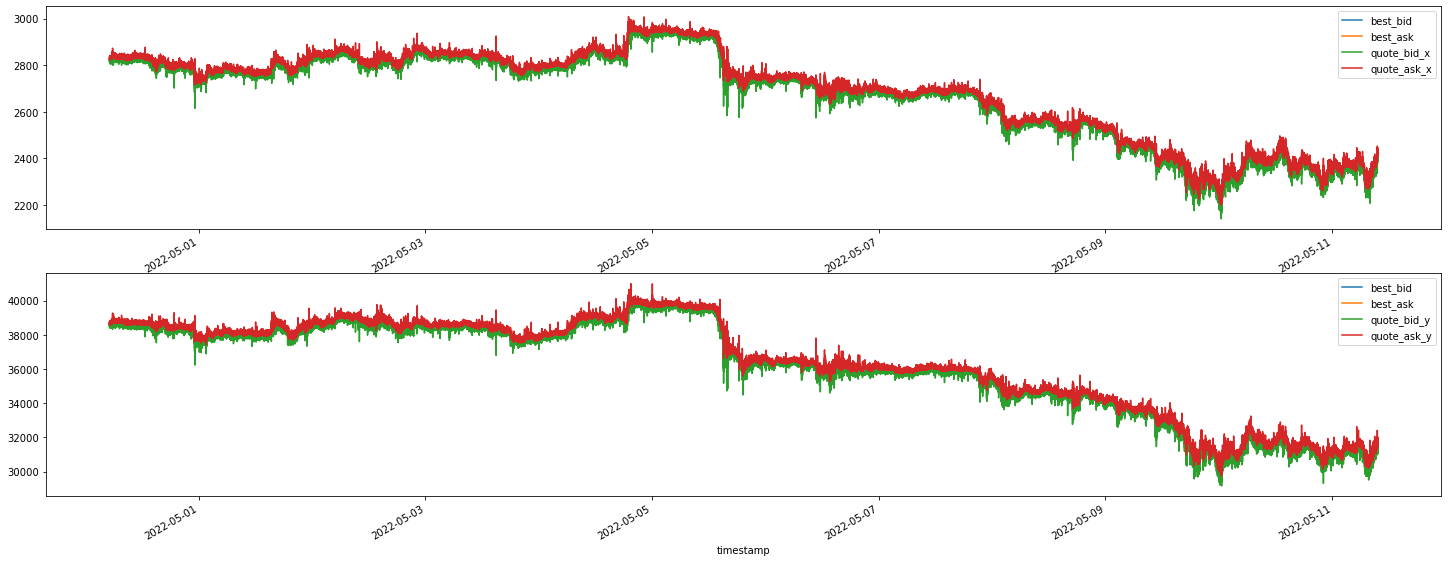

In [81]:
spread = 0.001
add = 0.003
THRESHOLD = 0.001
# treshold = 1
f_full = quotes(df)
print(f_full.shape)
f_full = f_full.iloc[:]
fig, axs = plt.subplots(2,1, figsize = (25,10))
f_full.bid1_price_x.plot(ax = axs[0], label = "best_bid")
f_full.ask1_price_x.plot(ax = axs[0], label = "best_ask")
f_full.quote_bid_x.plot(ax = axs[0])
f_full.quote_ask_x.plot(ax = axs[0])

f_full.bid1_price_y.plot(ax = axs[1], label = "best_bid")
f_full.ask1_price_y.plot(ax = axs[1], label = "best_ask")
f_full.quote_bid_y.plot(ax = axs[1])
f_full.quote_ask_y.plot(ax = axs[1])

for ax in axs:
    ax.legend()
plt.show()



In [76]:
df_store = pd.DataFrame({
    "spread":[],
    "add": [],
    "max_position": [],
    "max_delta": [],
    "profit": [],
    "vol": [],
})
i = 0
# for treshold in [0.00005,0.0001, 0.0002, 0.0005]:
for spread in [0.001, 0.0005, 0.0001]:
    for add in [0.002,0.001, 0.0005]:
        for max_position in [50, 100, 500]:
            for max_delta in [20, 50, 100]:
                if max_delta <= 2*max_position:
                        try:
                            eth_hist, btc_hist = simulate()
                            prof, vol = profit(eth_hist, btc_hist, verbose = 0)
                            print(f"SPREAD {spread} | ADD {add} | MAX_POS {max_position} | MAX_DELTA {max_delta} | PROFIT {prof} | VOLUME {vol}")
                            df_store.loc[i] = [spread, add, max_position, max_delta, prof, vol]
                            i += 1
                        except: pass

SPREAD 0.001 | ADD 0.002 | MAX_POS 50 | MAX_DELTA 20 | PROFIT -2.047105133821883 | VOLUME 16030
SPREAD 0.001 | ADD 0.002 | MAX_POS 50 | MAX_DELTA 50 | PROFIT -2.6952928361863977 | VOLUME 18610
SPREAD 0.001 | ADD 0.002 | MAX_POS 50 | MAX_DELTA 100 | PROFIT -2.130348195705114 | VOLUME 19750
SPREAD 0.001 | ADD 0.002 | MAX_POS 100 | MAX_DELTA 20 | PROFIT -1.6194866840804432 | VOLUME 16390
SPREAD 0.001 | ADD 0.002 | MAX_POS 100 | MAX_DELTA 50 | PROFIT -2.293107068913171 | VOLUME 18940
SPREAD 0.001 | ADD 0.002 | MAX_POS 100 | MAX_DELTA 100 | PROFIT -1.8933452159835789 | VOLUME 20160
SPREAD 0.001 | ADD 0.002 | MAX_POS 500 | MAX_DELTA 20 | PROFIT -1.5620066001639716 | VOLUME 16950
SPREAD 0.001 | ADD 0.002 | MAX_POS 500 | MAX_DELTA 50 | PROFIT -2.972628564121086 | VOLUME 19340
SPREAD 0.001 | ADD 0.002 | MAX_POS 500 | MAX_DELTA 100 | PROFIT -2.3654634415984104 | VOLUME 20490
SPREAD 0.001 | ADD 0.001 | MAX_POS 50 | MAX_DELTA 20 | PROFIT -0.9399589450641929 | VOLUME 9920
SPREAD 0.001 | ADD 0.001 |

In [84]:
spread = 0.0001
add = 0.002
max_position = 50
max_delta = 100
eth_hist, btc_hist = simulate()
prof, vol = profit(eth_hist, btc_hist, verbose = 2)
# print(f"SPREAD {spread} | ADD {add} | MAX_POS {max_position} | MAX_DELTA {max_delta} | PROFIT {prof} | VOLUME {vol}")

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000
410000
420000
430000
440000
450000
460000
470000
480000
490000
500000
510000
520000
530000
540000
550000
560000
570000
580000
590000
600000
610000
620000
630000
640000
650000
660000
670000
680000
690000
700000
710000
720000
730000
740000
750000
760000
770000
780000
790000
800000
810000
820000
830000
840000
850000
860000
870000
880000
890000
900000
910000
920000
930000
940000
950000
x -74.28561626016452 | y -79.30334187132355 | -153.58895813148808
x 2550.575008266131/2549.6824978496875 | y 34459.41833850544/34445.72996426588
x_vol: 424530 | y_vol: 399240


In [77]:
df_store = df_store.sort_values("profit",ascending=False, ignore_index=True)
# df_res.to_csv("testing.csv")
# df_res.head(50)
df_store.head(60)

,spread,add,max_position,max_delta,profit,vol
0,0.0001,0.0005,500.0,100.0,1.403709,32780.0
1,0.0001,0.0010,500.0,100.0,0.780639,32390.0
2,0.0010,0.0005,500.0,100.0,0.652501,3910.0
3,0.0001,0.0020,500.0,100.0,0.397905,32050.0
4,0.0010,0.0005,50.0,100.0,0.333005,3800.0
5,0.0010,0.0005,100.0,100.0,0.330649,3890.0
6,0.0010,0.0005,500.0,50.0,-0.309430,3700.0
7,0.0010,0.0005,100.0,50.0,-0.309430,3700.0
8,0.0005,0.0020,500.0,100.0,-0.499543,26330.0
9,0.0010,0.0005,500.0,20.0,-0.510635,3030.0


In [ ]:
fig, axs = plt.subplots(4,1, figsize = (15,7))
# axs = [axs]
eth_hist["position"].plot(ax = axs[0])
btc_hist["position"].plot(ax = axs[0])
f.bid1_price_x.plot(ax = axs[1])
f.bid1_price_y.plot(ax = axs[2])
(f.bid1_price_x / f.bid1_price_y).plot(ax = axs[3])


# pd.merge(eth_hist["position"], btc_hist["position"]).plot(ax = axs[0])
# (eth_hist["position"].ffill() + btc_hist["position"].ffill()).plot(ax = axs[1])
plt.show()

<AxesSubplot:xlabel='timestamp'>

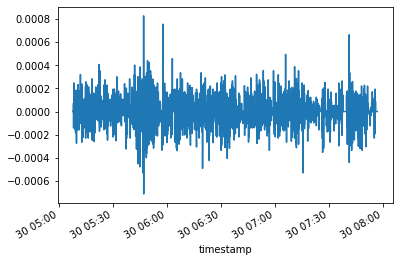

In [218]:
f_full.iloc[:10000].indicator.plot()


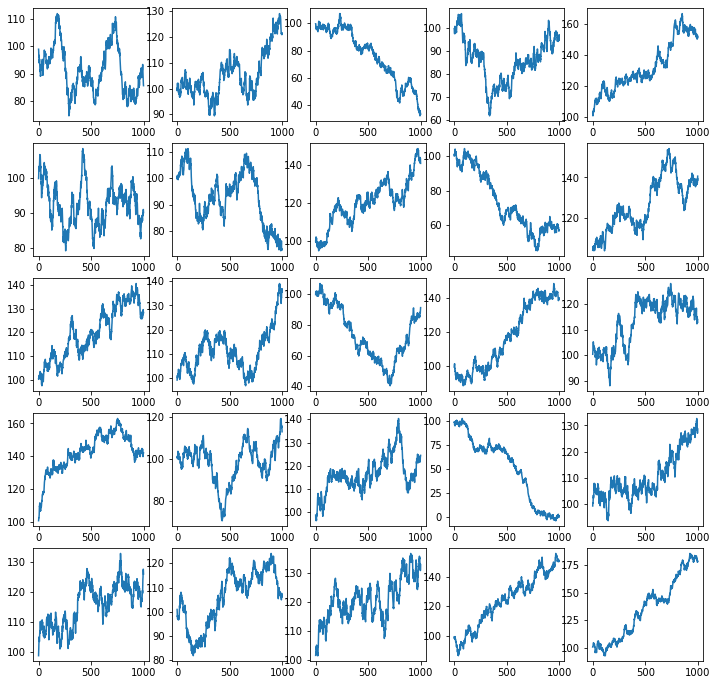

In [173]:
n = 5
m = 5
T = 1000
std = 1
val = 100
fig, axs = plt.subplots(n,m, figsize = (12,12))

for i in range(n):
    for j in range(m):
        res = np.cumsum(np.random.randn(T) * std) + 100
        axs[i, j].plot(res)
plt.show()

In [1]:
import pandas as pd

In [7]:
pd.read_csv("/Users/joeybesseling/Documents/Programmeren/Projects/Data/ETH-PERPETUAL/ETH-PERPETUAL_1_20(0).csv")

,Unnamed: 0,timestamp,bid1_price,bid1_size,ask1_price,ask1_size,bid2_price,bid2_size,ask2_price,ask2_size,...,bid20_price,bid20_size,ask20_price,ask20_size,trade_num,trade_vol,trade_num_buy,trade_vol_buy,trade_num_sell,trade_vol_sell
0,0,2022-04-18 09:40:04.463520512,2905.40,38301.0,2905.45,1114.0,2905.35,18741.0,2905.70,4000.0,...,2904.35,2000.0,2907.15,8758.0,1,5823.0,1,5823.0,0,0.0
1,1,2022-04-18 09:40:05.478960384,2905.40,38301.0,2905.45,1114.0,2905.35,18741.0,2905.70,4000.0,...,2904.40,47001.0,2907.15,8758.0,0,0.0,0,0.0,0,0.0
2,2,2022-04-18 09:40:06.494347008,2905.40,22001.0,2905.45,1114.0,2905.35,18741.0,2905.70,4000.0,...,2904.40,47001.0,2907.15,8758.0,0,0.0,0,0.0,0,0.0
3,3,2022-04-18 09:40:07.509736448,2905.40,22001.0,2905.45,1114.0,2905.35,18741.0,2905.70,4000.0,...,2904.40,61523.0,2907.15,8758.0,0,0.0,0,0.0,0,0.0
4,4,2022-04-18 09:40:08.521779968,2905.40,22001.0,2905.45,5114.0,2905.30,5001.0,2905.80,5000.0,...,2904.25,2904.0,2907.20,3026.0,0,0.0,0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7913,7913,2022-04-18 12:45:18.547804928,2939.55,1763.0,2939.60,45280.0,2939.00,18753.0,2939.65,5000.0,...,2937.05,5000.0,2940.80,3208.0,0,0.0,0,0.0,0,0.0
7914,7914,2022-04-18 12:45:19.570826496,2939.55,1763.0,2939.60,45280.0,2939.00,1411.0,2939.65,5000.0,...,2937.25,110257.0,2940.80,3208.0,0,0.0,0,0.0,0,0.0
7915,7915,2022-04-18 12:45:20.587745024,2939.55,1763.0,2939.60,32780.0,2939.35,19002.0,2939.80,11502.0,...,2937.50,8424.0,2941.05,7101.0,0,0.0,0,0.0,0,0.0
7916,7916,2022-04-18 12:45:21.604583168,2939.55,1763.0,2939.60,45280.0,2939.35,18753.0,2939.80,11502.0,...,2937.60,150.0,2941.10,29411.0,0,0.0,0,0.0,0,0.0
